# Animating the French deaths

## Introduction

In this notebook, we use open data from the French National Institute of Statistics and Economic Studies ([INSEE](https://www.insee.fr/en/accueil)) in order to animate the age distribution of deaths over time for the last decades.
We also want to compare the women and men distributions.
We make use of [Pandas](https://pandas.pydata.org/), [Matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/) libraries.

The dataset is downloaded from the "[Fichier des personnes décédés](https://www.insee.fr/fr/information/4190491)".
It is reliable on the 1971-2021 period.

## Some parameters

Starting with some useful parameters.

In [93]:
BINS = 120  # Number of age bins for histograms
YEARS = tuple(range(1972, 2022))  # the 1972-2021 period will be covered
ANNOTATIONS = {1914: '1914-1918: World War I',
               1918: '',
               1946: '1946: Babyboom'}

## Processing INSEE data


### Data downloading

We want to automatically download data from INSEE website <https://www.insee.fr/fr/information/4190491>.
The whole dataset represents 2.3Gb.

Let's first define a function to download and unzip any remote archive.

In [ ]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

def download_unzip(zipurl, destination):
    """Download zipfile from URL and extract it to destination"""
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(destination)

Now we download and extract the last decades archives to `data/` directory.

In [ ]:
for decade in 1970, 1980, 1990, 2000, 2010:
    url = f"https://www.insee.fr/fr/statistiques/fichier/4769950/deces-{decade}-{decade + 9}-csv.zip"
    print("Downloading and extracting", url)
    download_unzip(url, 'data')

Download and extract last years archives to `data/` directory.

In [ ]:
for year in 2020, 2021:
    url = f"https://www.insee.fr/fr/statistiques/fichier/4190491/Deces_{year}.zip"
    print("Downloading and extracting", url)
    download_unzip(url, 'data')

The extractions produce a CSV file per year:

In [ ]:
import os
print(' '.join(sorted(os.listdir('data/'))))

All files are not named following the same rule so we normalize the file names:

In [ ]:
import glob
from pathlib import Path
for filename in glob.glob('data/*.csv'):
    newfilename = filename.lower().replace('_', '-')
    Path(filename).rename(newfilename)
print(' '.join(sorted(os.listdir('data/'))))

### Data loading

We now load the data from the CSV file by selecting three columns: `sexe`, `datenaiss` and `datedeces`.

In [ ]:
import pandas as pd
import numpy as np

csv_files = sorted(glob.glob('data/*.csv'))
n_files = len(csv_files)
df_years = []
for i, csv_file in enumerate(csv_files):
    print(f"Loading {csv_file} ({i + 1}/{n_files})", end='\r', flush=True)
    df_year = pd.read_csv(csv_file,
                          sep=';',
                          usecols=[1, 2, 6],
                          parse_dates=['datenaiss', 'datedeces'],
                          infer_datetime_format=True,
                          date_parser=lambda x: pd.to_datetime(
                              x, errors='coerce'),
                          na_filter=False)
    df_years.append(df_year)
df = pd.concat(df_years, axis=0, ignore_index=True)
del df_years  # free memory
print()

The pandas DataFrame `df` looks like this:

In [14]:
df

Perform some processing:

- filter out missing data,
- select the target period,
- build women and men dataframes.

In [15]:
# remove entries containing missing values
df.dropna(axis='index', inplace=True)
df['age'] = (df['datedeces'] - df['datenaiss']) / \
    np.timedelta64(1, 'Y')
df = df[df['age'] >= 0]
df = df[min(YEARS) <= df['datedeces'].dt.year]
df = df[df['datedeces'].dt.year <= max(YEARS)]
# We will need to group by year of death
df['death_year'] = df['datedeces'].dt.year
women = df[df.sexe == 2]  # a subset containing women
men = df[df.sexe == 1]  # a subset containing men

Printout dataframe sizes.

In [ ]:
print(f"{'Dataframe':<10} Number of entries")
template_line = "{:<10} {:,}"
print(template_line.format('df', len(df)))
print(template_line.format('women', len(women)))
print(template_line.format('men', len(men)))

## Plotting the data

### Deaths over the years

Let's plot the number of deaths over the year during the target period.

In [18]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 8]  # Set default figure size
sns.set()

by_year = df.groupby('death_year').size()
by_year_women = women.groupby('death_year').size()
by_year_men = men.groupby('death_year').size()
ax = by_year.plot(label="Total")
by_year_women.plot(style='--', ax=ax, label="Women")
by_year_men.plot(style='-.', ax=ax, label="Men")
ax.set_ybound(lower=0)
ax.set_xlabel("Year")
ax.set_title("Number of deaths")
ax.legend();

### Animating the total deaths

Let's define an utilitary function to extract a subdataframe.

In [19]:
def get_year(df: pd.DataFrame, year: int) -> pd.DataFrame:
    """Return sub dataframe corresponding to decease year"""
    return df[df['datedeces'].dt.year == year]

Then let's write a function that creates a histogram from the dataframe for a given year.

<IPython.core.display.Javascript object>


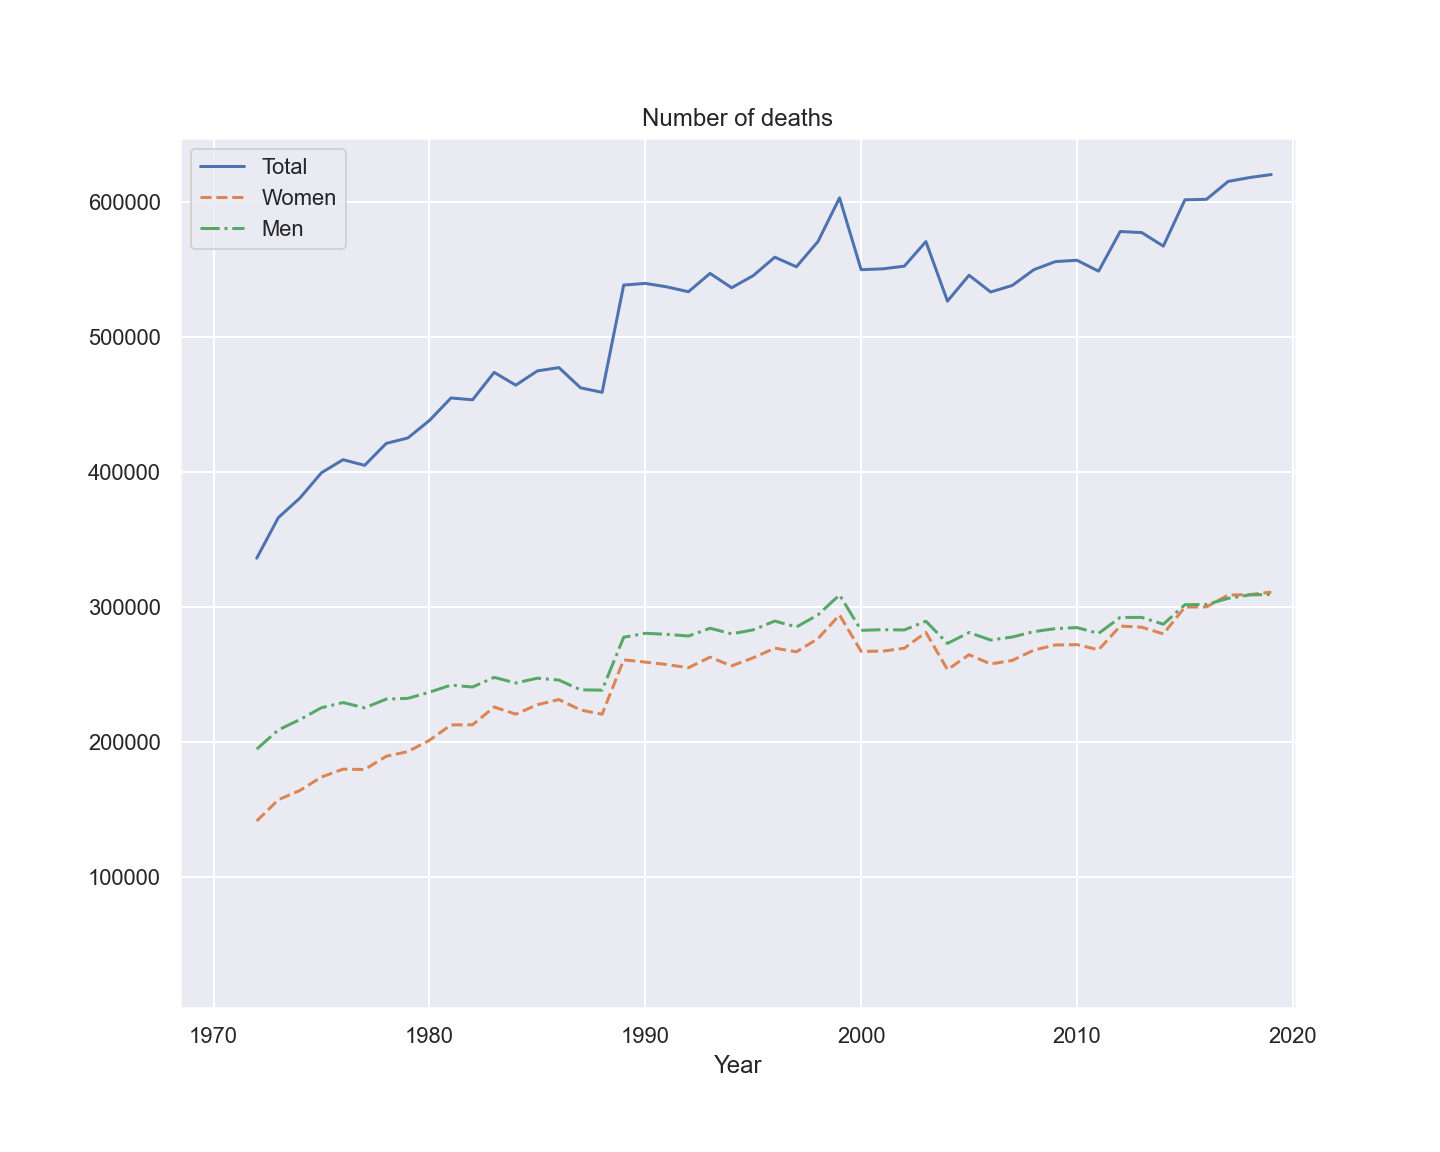

In [32]:
def plot_year(df: pd.DataFrame, year: int, annotate=False):
    """Plot one year histogram ad return fig, ax and bar_container"""
    # Initialize figure
    fig, ax = plt.subplots()
    ax.set_xlabel('Age of death (years)')
    _, _, bar_container = ax.hist(get_year(df, year)['age'],
                                  BINS,
                                  range=[0, BINS])
    fig.suptitle("Distribution of the age of death in France")
    ax.set_title(f"Year of death: {year}")
    ax.set_xlim([0, BINS])
    ax.set_ylim([0, 27500])
    ax.set_ylabel("Number of deaths")
    annotations = {}
    if annotate:
        for birthyear, text in ANNOTATIONS.items():
            age = year - birthyear
            vl = ax.axvline((age - 1, ), color='r', linewidth=0.75)
            text = ax.text(age - 10, 23000, text, color='r',
                           bbox=dict(facecolor='white', alpha=0.75))
            annotations[birthyear] = (vl, text)
    return fig, ax, (bar_container, annotations)

Let's try this function for the year 1983.

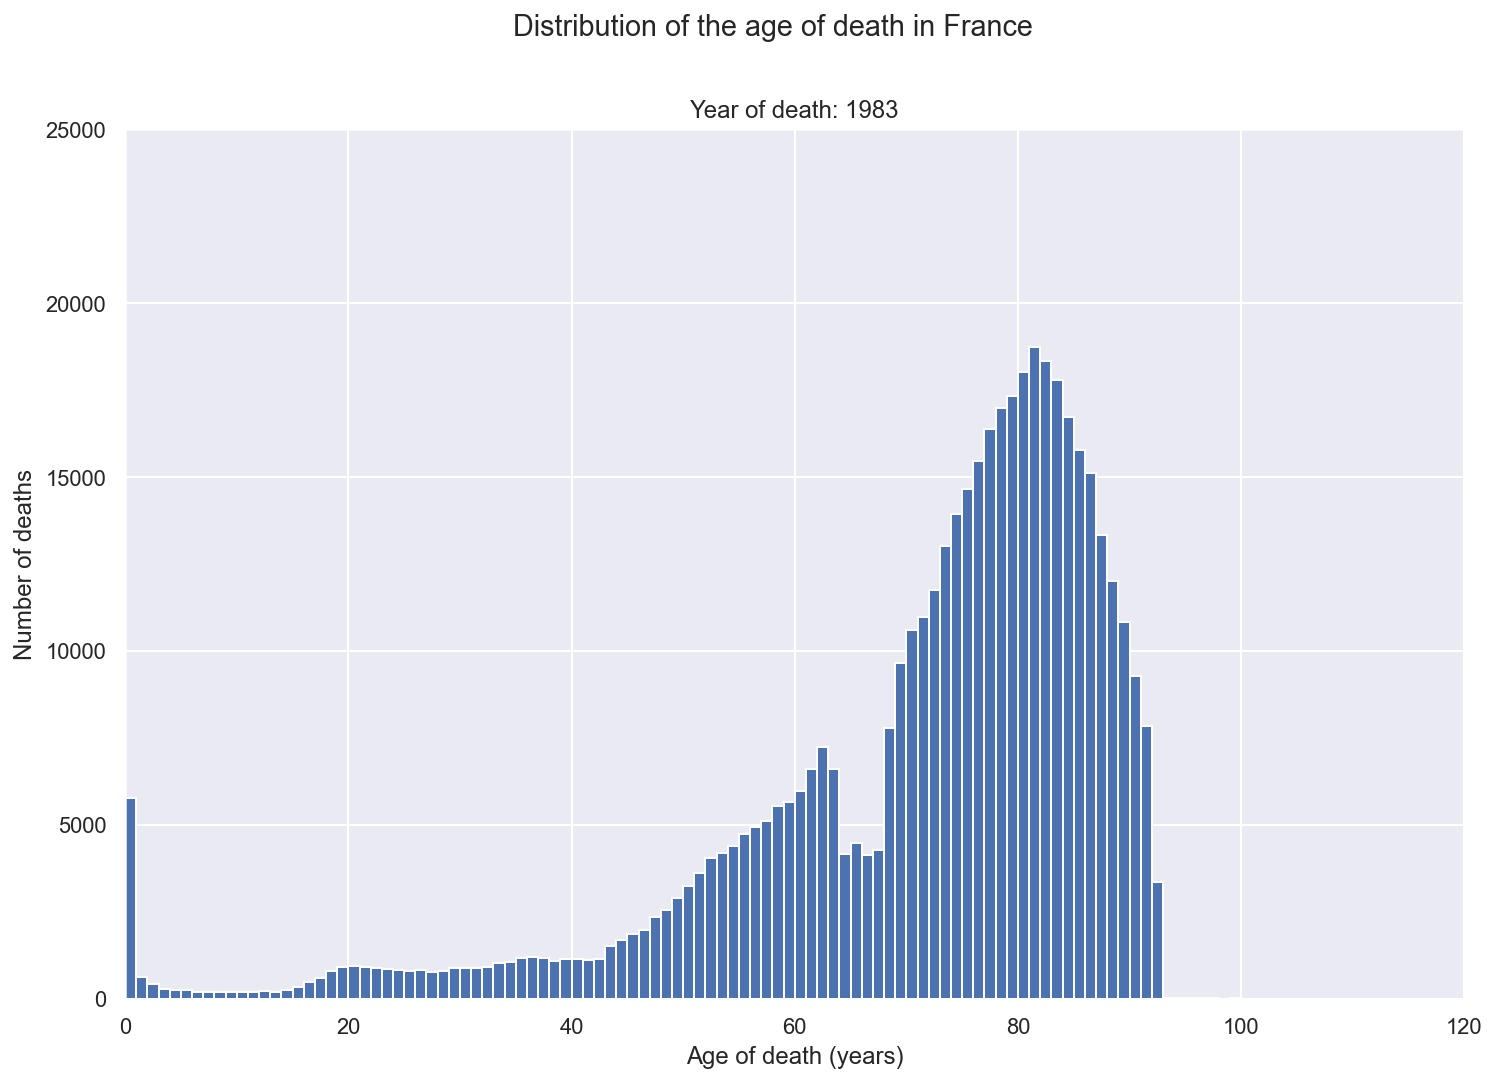

In [196]:
plot_year(df, 1983);

Let's now add some useful annotations.

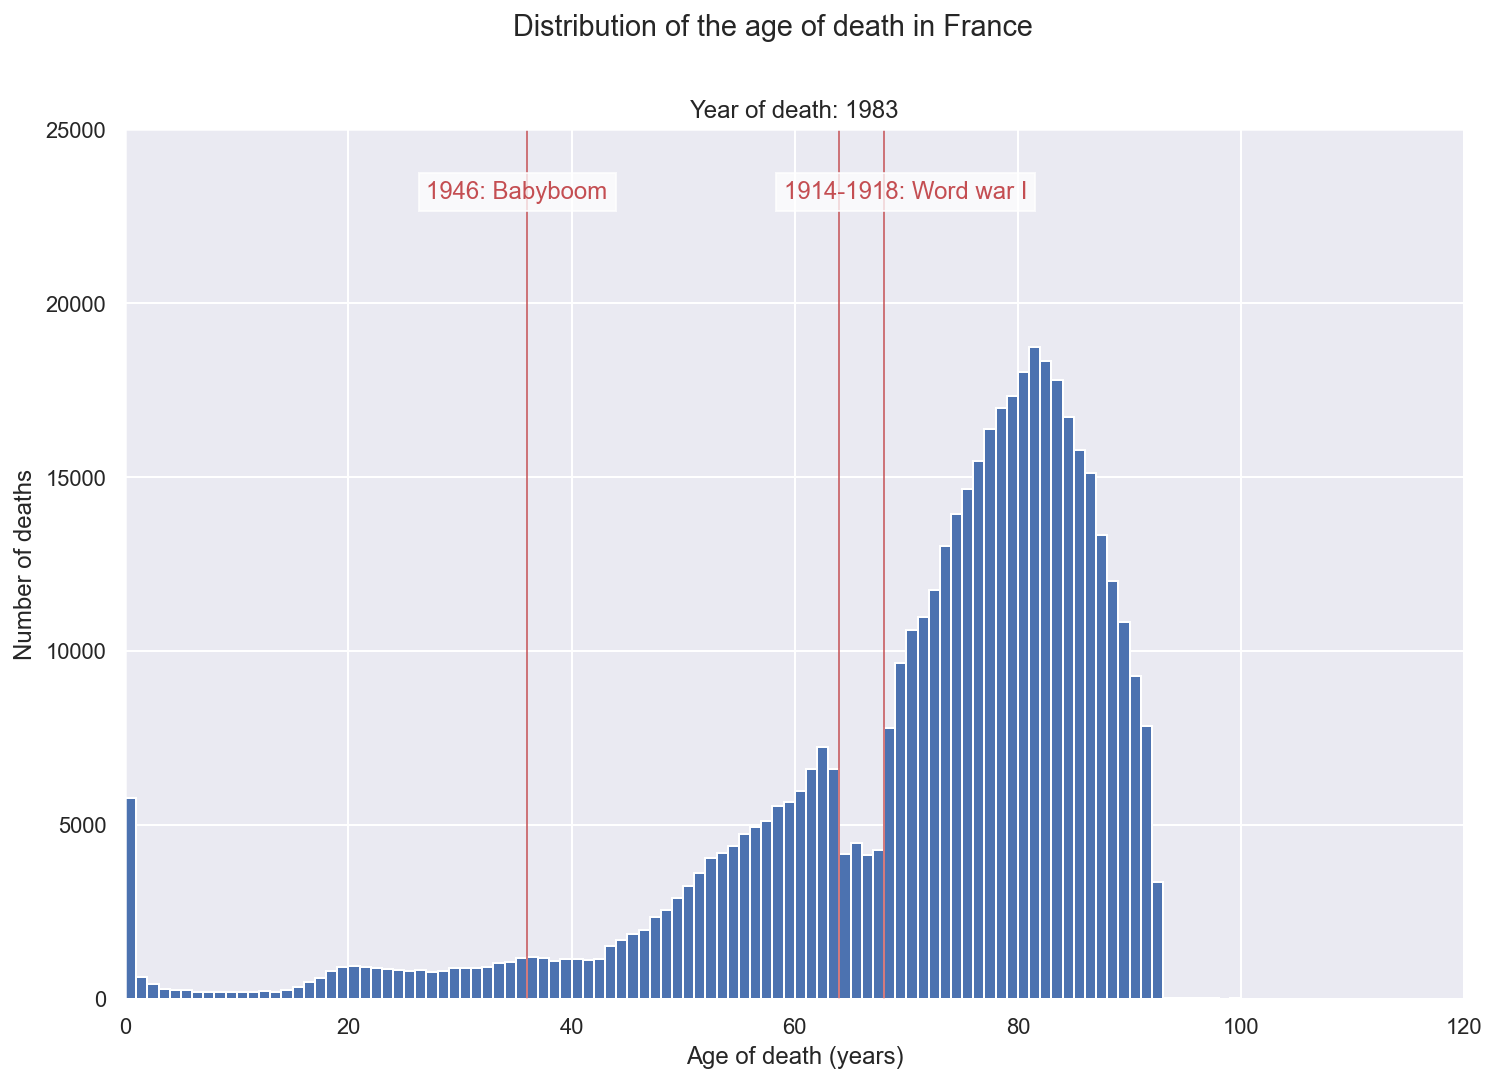

In [175]:
plot_year(df, 1983, annotate=True);

We now create a matplotlib animation following this [tutorial](https://matplotlib.org/stable/gallery/animation/animated_histogram.html) and looping over the 1971-2021 period.

In [73]:
import matplotlib.animation as animation
from IPython.display import HTML


def update(bar_container, annotations):
    """Update ax for animation"""

    def animate(year):
        age = get_year(df, year)['age']
        print(f"{year}: {len(age)}", end='\r')
        n, _ = np.histogram(age, BINS, range=[0, BINS])
        ax.set_title(f"Year of death: {year}")
        if annotations:
            for birthyear, (vl, text) in annotations.items():
                age = year - birthyear
                vl.set_xdata(age - 1)
                text.set_x(age - 10)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        return bar_container.patches

    return animate


fig, ax, artists = plot_year(df, YEARS[0], annotate=True)  # First plot
# Build animation
anim = animation.FuncAnimation(fig, update(*artists), YEARS,
                               blit=True, repeat=False)
# Record animation as js video
video = anim.to_jshtml(default_mode='loop')
plt.close()  # To prevent from displaying a fixed figure
HTML(video)  # Display video

### Comparing women and men

We now want to compare the distribution of the age of death between women and men. The following dataclass will store women and men data.

In [197]:
import dataclasses

@dataclasses.dataclass
class Dataset:
    """Class for storing a named dataset and its visual elements"""
    name: str
    data: pd.DataFrame
    ax: matplotlib.axes.SubplotBase
    barcontainer: matplotlib.container.BarContainer = None
    annotate: str = None
    annotations: dict = dataclasses.field(default_factory=dict)


    def set_ax_params(self, bins: int, xmax: int, xlabel: str, year: int):
        """Set parameters to ax"""
        self.ax.set_title(self.name)
        self.ax.set_ylim([0, bins])
        self.ax.set_xlabel(xlabel)
        self.ax.set_xlim([0, xmax])
        if self.annotate:
            for birthyear, text in ANNOTATIONS.items():
                age = year - birthyear
                vl = self.ax.axhline((age - 1, ), color='r', linewidth=0.75)
                if self.annotate != 'hlines':
                    text = self.ax.text(14000, age + 1, text, color='r')
                else:
                    text = None
                self.annotations[birthyear] = (vl, text)        

Let's define a function that plots a comparative women/men histogram for a given year.

In [198]:
def plot_year_wm(women, men, year: int):
    """Plot one year histogram and return fig and Datasets"""
    # Initialize figure
    fig, axes = plt.subplots(ncols=2, sharey=True)
    fig.suptitle(f"Distribution of the age of death in France in {year}")

    w = Dataset(name="Women", data=women, ax=axes[0], annotate='both')
    m = Dataset(name="Men", data=men, ax=axes[1], annotate='hlines')

    for s in w, m:
        _, _, s.bar_container = s.ax.hist(
            get_year(s.data, year)['age'],
            BINS,
            range=[0, BINS],
            orientation='horizontal')
        s.set_ax_params(BINS, 16000, "Number of deaths", year)

    # These parameters are specific to left plot
    w.ax.invert_xaxis()
    w.ax.set_ylabel("Age of death (years)")

    fig.tight_layout()
    return fig, (w, m)

Let's try this function for the year 1983.

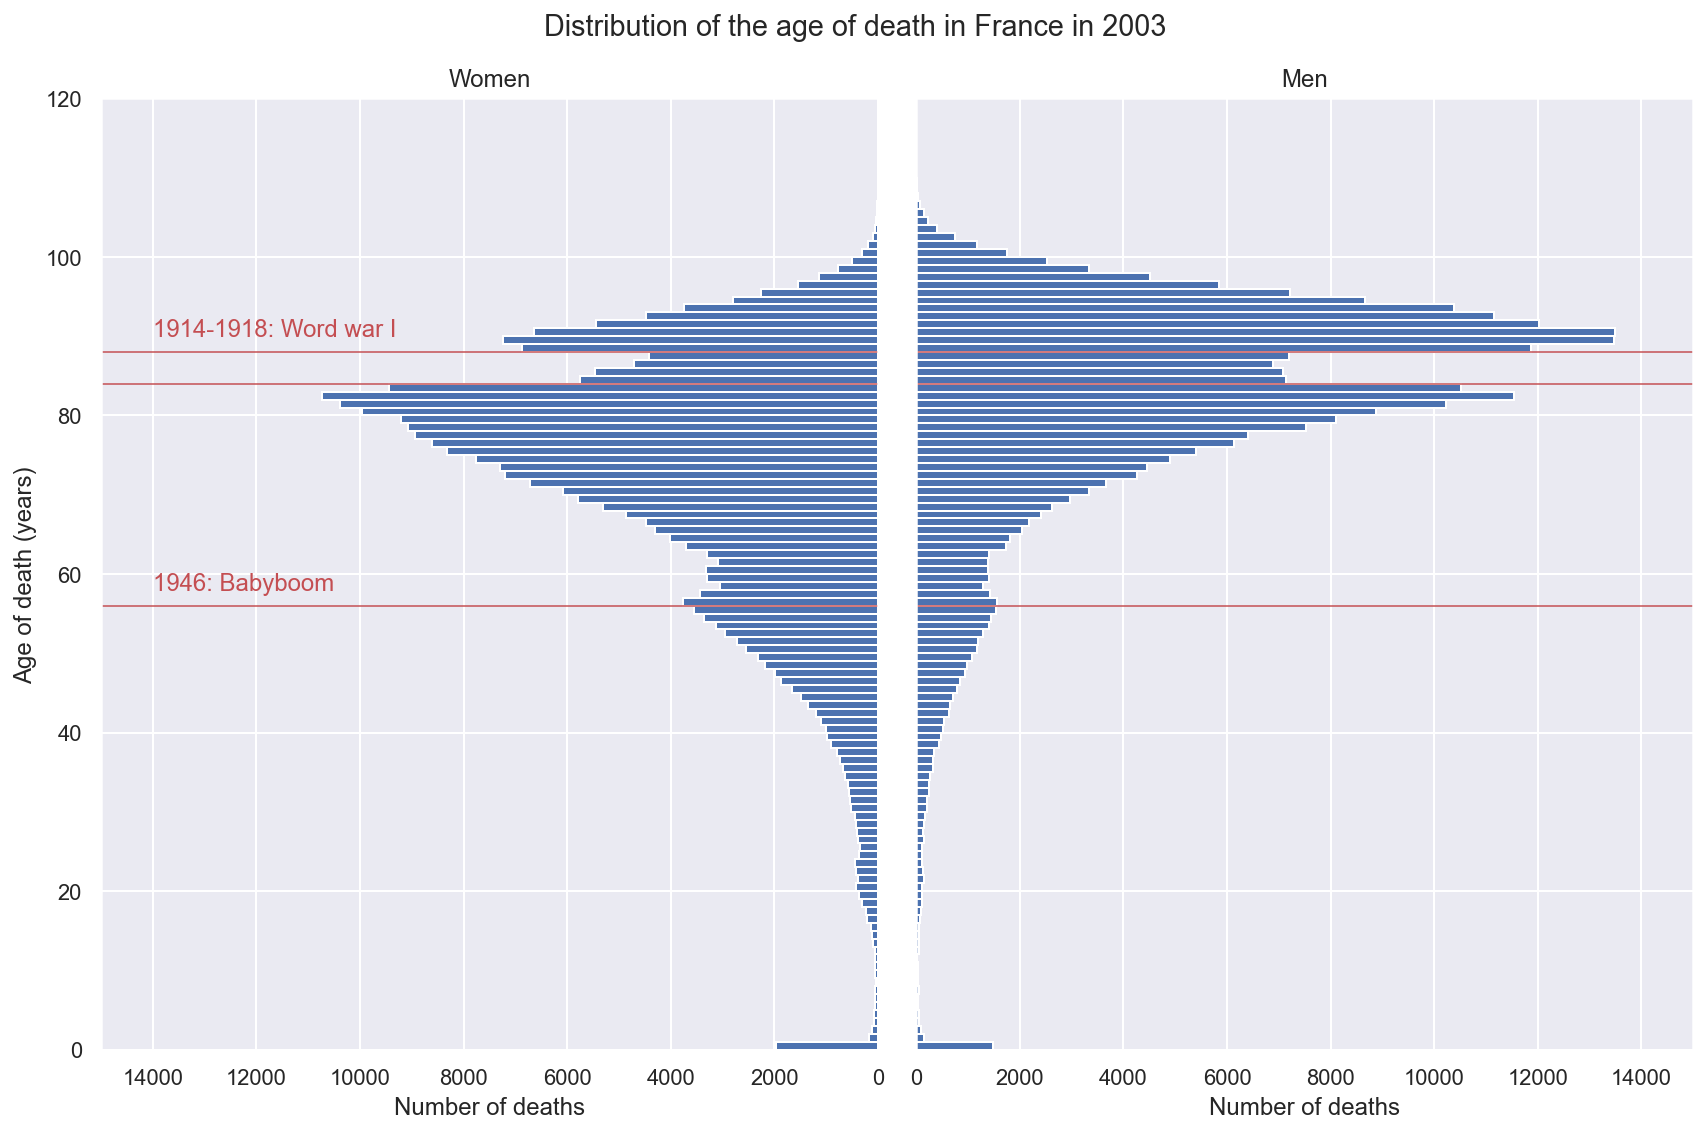

In [200]:
fig, (w, m) = plot_year_wm(women, men, 1983);

We now create an animation for theses histograms on the 1971-2021 period.

In [201]:
def update_wm(wm):
    """Update ax for animation"""

    def animate(year):
        fig.suptitle(
            f"Distribution of the age of death in France in {year}")
        for s in wm:
            age = get_year(s.data, year)['age']
            s.len = len(age)
            n, _ = np.histogram(age, BINS, range=[0, BINS])
            for count, rect in zip(n, s.bar_container.patches):
                rect.set_width(count)
            if s.annotations:
                for birthyear, (vl, text) in s.annotations.items():
                    age = year - birthyear
                    vl.set_ydata(age - 1)
                    if text:
                        text.set_y(age + 1)
        print(f"{year}: {wm[0].len} women, {wm[1].len} men", end='\r',
                flush=True)
        return s.bar_container.patches

    return animate

fig, wm = plot_year_wm(women, men, YEARS[0])  # First plot
anim_wm = animation.FuncAnimation(fig, update_wm(wm), YEARS,
                                blit=True, repeat=False)
video_wm = anim_wm.to_jshtml(default_mode='loop')
plt.close()
HTML(video_wm)

We finally save the animation as a GIF file.

In [203]:
anim_wm.save("deaths_wm.gif", fps=12)
plt.close()

## Conclusion

In this notebook, we used pandas and matplotlib to plot animated time evolving histograms from open data.
The dataset from the French National Institute of Statistics and Economic Studies contains 26 millions entries over a 50-year period.
No interpretation of the results is given: it is entirely left to the reader and to demographers!